# **Objetivo da Análise**

Este notebook apresenta uma metodologia para organização e categorização automática de grandes volumes de artigos científicos através de técnicas avançadas de processamento de linguagem natural e aprendizado de máquina. O objetivo principal é transformar uma coleção massiva de aproximadamente 222.259 artigos do arXiv em bibliotecas temáticas especializadas, facilitando o acesso e a gestão do conhecimento científico.

Aqui será realizada uma análise completa, clusterização e categorização de artigos científicos do arXiv utilizando técnicas de Processamento de Linguagem Natural (PLN) e aprendizado de máquina não supervisionado.

A explosão de produção científica representa um desafio significativo para organização e recuperação de informação. Este projeto aborda esse problema através de uma abordagem sistemática que combina embeddings de texto, redução de dimensionalidade e técnicas de clusterização para criar subconjuntos temáticos coerentes a partir de uma grande biblioteca heterogênea.

# **Configuração Inicial e Importações**

**Instalação das bibliotecas essenciais**

*   langchain_community e langchain_openai: Para integração com modelos de linguagem

*   faiss-cpu: Para busca por similaridade em espaços vetoriais

*   tiktoken: Para tokenização de texto

In [1]:
!pip install langchain_community
!pip install langchain_openai
!pip install faiss-cpu
!pip install tiktoken
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.11
    Uninstalling langchain-text-splitters-0.3.11:
      Successfully uninstalled langchain-text-splitters-0.3.11
ERROR: pip's dependency resolver

**Importação de bibliotecas para**

*   Manipulação de dados (pandas, numpy)

*   Visualização (matplotlib, seaborn, wordcloud)

*   Machine Learning (scikit-learn, xgboost, tensorflow)

*   Redução de dimensionalidade (UMAP, t-SNE)

In [2]:
import os
from langchain_community.vectorstores import FAISS
from langchain_openai  import OpenAIEmbeddings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import pandas as pd
from sklearn.manifold import TSNE
from google.colab import userdata
import umap
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import time

# NLTK Stop words
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

import warnings
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Carregamento dos Dados**

Utilizou-se o modelo text-embedding-3-large da OpenAI para converter o conteúdo textual dos artigos em representações vetoriais densas. Esses embeddings capturam semântica e relações contextuais, servindo como base para as operações subsequentes de similaridade e agrupamento.

**Configuração da API key da OpenAI**

*   Embeddings de Texto: OpenAI Embeddings para representação semântica

**Carregamento do banco de vetores FAISS contendo embeddings dos artigos**

*   Banco de Vetores: FAISS para armazenamento e busca eficiente

**Estrutura dos dados**

*   222.259 artigos científicos

*   Metadados: título, autores, DOI, data, conteúdo

*   Embeddings gerados com o modelo text-embedding-3-large

In [3]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [4]:
folder_path = '/content/drive/MyDrive/Pesquisas/GetenciamentoArXiv/'
text_files = [f for f in os.listdir(folder_path)]
embeddings = OpenAIEmbeddings(model="text-embedding-3-large",chunk_size=4000,max_retries=3)
biblioteca = FAISS.load_local(f'{folder_path}', embeddings,allow_dangerous_deserialization=True)


In [5]:
faiss_index = biblioteca.index

num_embeddings = faiss_index.ntotal
print(f"Number of embeddings in the index: {num_embeddings}")

Number of embeddings in the index: 222259


In [6]:
def MostrarVectorstore(vectorstore):
  v_dict = vectorstore.docstore._dict
  data_rows = []
  for i, k in enumerate(v_dict.keys()):
    doc = v_dict[k].metadata
    doc['id'] = k
    doc['content'] = v_dict[k].page_content
    data_rows.append(doc)
  embeddings_array = faiss_index.reconstruct_n(0, num_embeddings)
  dados = pd.DataFrame(data_rows)
  if len(dados) == len(embeddings_array):
      dados['embedding'] = [row for row in embeddings_array]
  else:
      print("Warning: Number of documents in docstore does not match the number of embeddings. Cannot add embeddings column.")
      dados['embedding'] = None


  return dados

df_vectorstore = MostrarVectorstore(biblioteca)
display(df_vectorstore)

,id,title,authors,doi,update_date,ano,content,embedding
0,3cac8447-5ec0-47d7-a572-6b067325d89d,The Veldkamp Space of Two-Qubits,"Metod Saniga (ASTRINSTSAV), Michel Planat (FEM...",10.3842/SIGMA.2007.075,2024-02-13,2024,Given a remarkable representation of the gen...,"[0.012992965, -0.0101996055, -0.025242742, 0.0..."
1,ca01b699-025d-4878-8196-25b5803c06b3,Metric Properties of Conflict Sets,"Lev Birbrair, Dirk Siersma",None,2024-07-22,2024,In this paper we show that the tangent cone ...,"[0.016964134, -0.016898073, -0.019487614, -0.0..."
2,cd7a772e-dd5b-4651-9ddb-24f59a2131b9,"Quasi Ordinary Singularities, Essential Diviso...","Pedro Daniel Gonzalez Perez, Fernando Hernando",10.1112/jlms/jdp014,2024-05-01,2024,We define Poincar\'e series associated to a ...,"[0.0012992191, 0.020367838, -0.030327935, -0.0..."
3,a2c29f77-7407-45c4-b875-70fe4626e9d0,Third Order Newton's Method for Zernike Polyno...,Richard J. Mathar,None,2024-04-23,2024,The Zernike radial polynomials are a system ...,"[-0.023782989, -0.056863435, -0.018376598, 0.0..."
4,f0dcf583-91b0-45b7-b9a0-6e5ef996dd8e,Quantum Properties and Gravitational Field of ...,Hou Y. Yau,None,2024-04-22,2024,We find that a field with oscillations of ma...,"[0.011499766, -0.03162436, -0.009550887, 0.032..."
...,...,...,...,...,...,...,...,...
222254,95cfcbc1-64ff-443b-b5f9-1d5c45f2b9ab,A Gravitational Explanation for Quantum Mechanics,Mark J. Hadley,None,2024-01-03,2024,It is shown that certain structures in class...,"[-0.014616687, -0.028870052, -0.02084904, 0.01..."
222255,0f8ddbce-e9bf-4344-b091-d6c947d9f241,The Logic of Quantum Mechanics Derived from Cl...,"Mark J. Hadley (Univ. of Warwick, UK)",10.1007/BF02764119,2024-01-03,2024,For the first time it is shown that the logi...,"[-0.001411531, -0.0037992909, -0.018705186, 0...."
222256,b6707ed4-8e5f-471e-96a9-911a43ebc314,Coloring the rational quantum sphere and the K...,"Hans Havlicek, Guenther Krenn, Johann Summhamm...",10.1088/0305-4470/34/14/312,2024-02-13,2024,We review and extend recent findings of Gods...,"[0.016963162, -0.029218843, -0.027839065, 0.02..."
222257,60d0d7c7-c0c6-48e4-a871-0d03544a0bb7,Integer spin particles necessarily produce hal...,"Troy Shinbrot (Rutgers University, Piscataway,...",10.1063/1.5116695,2024-05-14,2024,Exact wave functions are is derived from an ...,"[-0.020337686, -0.026285997, -0.01431024, 0.01..."


# **Pré-processamento e Amostragem**

Dado o volume considerável de dados, adotou-se uma abordagem em duas fases. Inicialmente, uma amostra representativa de 8.000 artigos foi selecionada através de amostragem estratificada, representando aproximadamente 3,6% do total. Esta amostra permitiu a viabilidade computacional da análise inicial sem comprometer a representatividade dos dados.

In [7]:
sample_size = 8000
embeddings_sample, _ = train_test_split(
    df_vectorstore,
    train_size=sample_size,
    random_state=42,
)

# **Redução de Dimensionalidade com UMAP ou t-SNE**

Existe a possibilidade de utilizar o algoritmo **t-SNE (t-Distributed Stochastic Neighbor Embedding)** que utiliza o algoritmo de redução dimensional não-linear focado em preservação de estruturas locais para reduzir a dimensionalidade de dados, transformando embeddings de alta dimensão em uma representação 3D para visualização. Contudo, essa abordagem possui algumas limitações:

*   Não preserva distâncias absolutas: t-SNE preserva estruturas locais, não globais.Clusters próximos são similares, mas distância exata não tem significado

*   Custo computacional: O(n²) - pode ser lento para grandes datasets

*   Resultados não determinísticos: é um modelo probabilistico, utiliza a distribuição t-Student para modelar similaridades no espaço de baixa dimensão

**Redução de Dimensionalidade com UMAP**

Por conta disto, foi utilizado o **UMAP (Uniform Manifold Approximation and Projection)** para a redução de dimensionalidade, pois este possui as seguintes características:

*   Baseado em teoria topológica e variedades de Riemann (modelagem topológica/algebraica)

*   Preserva tanto estrutura local quanto global dos dados

*   Custo computacional: O(n) - eficiente para grandes datasets

**Configuração otimizada para grandes volumes de dados**

*   Redução para 100 dimensões

*   Parâmetros: n_neighbors=20, min_dist=0.001, métrica cosseno

*   Otimizações de performance: low_memory=True, angular_rp_forest=True

In [8]:
dimensoes = 100
reducer = umap.UMAP(
    # Parâmetros essenciais
    n_components=dimensoes,
    n_neighbors=20,
    min_dist=0.001,
    metric='cosine',

    # Otimização e performance
    n_epochs=None,
    learning_rate=0.1,
    init='spectral',
    low_memory=True,

    # Parâmetros avançados
    spread=2.0,
    random_state=42,
    angular_rp_forest=True,
    verbose=True
)
embeddings_3d = reducer.fit_transform(np.stack(embeddings_sample['embedding']))

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, learning_rate=0.1, metric='cosine', min_dist=0.001, n_components=100, n_jobs=1, n_neighbors=20, random_state=42, spread=2.0, verbose=True)
Wed Oct 22 15:37:57 2025 Construct fuzzy simplicial set
Wed Oct 22 15:37:57 2025 Finding Nearest Neighbors
Wed Oct 22 15:37:58 2025 Building RP forest with 9 trees
Wed Oct 22 15:38:04 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Wed Oct 22 15:38:26 2025 Finished Nearest Neighbor Search
Wed Oct 22 15:38:29 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Oct 22 15:39:32 2025 Finished embedding


In [9]:
df_tsne = pd.DataFrame(embeddings_3d, columns=[f'UMAP{i+1}' for i in range(dimensoes)])
df_tsne

,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAP10,...,UMAP91,UMAP92,UMAP93,UMAP94,UMAP95,UMAP96,UMAP97,UMAP98,UMAP99,UMAP100
0,1.712705,5.674115,6.467369,6.887154,5.344659,1.703767,6.575810,3.573253,5.200563,5.465896,...,5.105586,4.449274,4.056571,4.983438,4.687811,4.486713,3.332488,4.911529,5.996399,4.556869
1,8.147067,5.216834,0.604179,8.024166,3.376353,2.170873,6.313187,4.361012,5.238982,4.879335,...,5.127404,4.493970,4.036318,4.939348,4.681842,4.550936,3.321683,4.877276,5.998857,4.540564
2,4.641037,2.163125,7.598719,6.952569,4.228259,2.510481,6.387519,3.556828,5.276250,5.210721,...,5.126244,4.473217,4.065773,4.996694,4.716442,4.516242,3.315712,4.868720,5.995981,4.546252
3,10.405265,7.958766,7.683002,6.581278,3.785994,2.564689,5.937659,4.249820,5.607182,4.571435,...,5.140947,4.510437,4.065328,4.964640,4.694524,4.523818,3.318285,4.854698,5.934348,4.527057
4,4.322924,4.910098,4.847918,7.288994,5.123590,1.895438,6.405663,3.859494,5.230354,4.821751,...,5.133255,4.440882,4.071296,4.988750,4.689529,4.502131,3.323977,4.898526,6.000303,4.539845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,1.734324,6.865237,5.293006,7.077710,5.863832,5.761098,5.607075,4.185925,3.769918,3.750922,...,5.163123,4.506765,4.074375,5.092709,4.618097,4.733510,3.348902,4.930092,5.961843,4.647824
7996,-0.781950,7.810234,6.708745,6.425114,2.705043,2.116133,6.176512,3.580013,4.889296,4.225240,...,5.116615,4.466848,4.110984,4.982102,4.608648,4.518829,3.307189,4.898923,5.983484,4.600207
7997,5.363086,4.217731,5.268405,7.420153,6.386404,1.760025,6.950192,5.108867,5.202381,4.537614,...,5.109091,4.482465,4.064472,4.977311,4.672430,4.535939,3.357667,4.855473,6.006172,4.517402
7998,7.930802,4.910688,3.728819,6.998577,4.582292,2.588140,5.350812,3.427442,6.476142,4.123180,...,5.146698,4.508739,4.101407,4.991052,4.696048,4.548810,3.328197,4.834095,6.006815,4.545671


# **Visualização Exploratória**

*   Criação de visualizações 3D interativas dos embeddings reduzidos

*   Gráficos de dispersão mostrando a distribuição dos artigos no espaço UMAP

*   Perspectivas múltiplas para análise da estrutura dos clusters

/tmp/ipython-input-3856571420.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(df_tsne['UMAP1'], df_tsne['UMAP2'], df_tsne['UMAP3'], cmap='viridis')


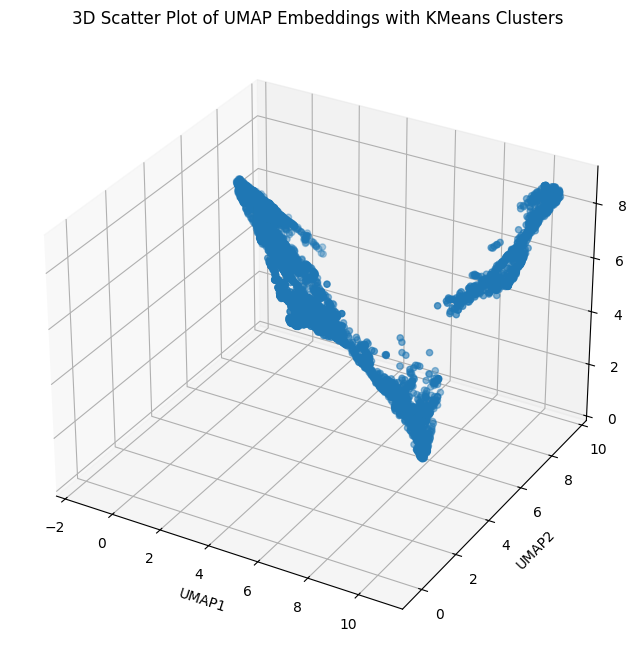

/tmp/ipython-input-3856571420.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(df_tsne['UMAP1']*(-1), df_tsne['UMAP2'], df_tsne['UMAP3'], cmap='viridis')


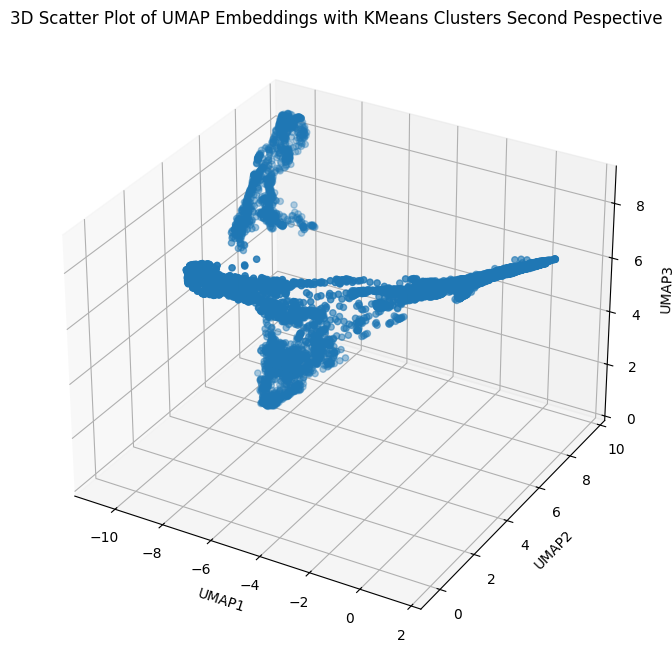

In [10]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_tsne['UMAP1'], df_tsne['UMAP2'], df_tsne['UMAP3'], cmap='viridis')

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
plt.title('3D Scatter Plot of UMAP Embeddings with KMeans Clusters')

plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_tsne['UMAP1']*(-1), df_tsne['UMAP2'], df_tsne['UMAP3'], cmap='viridis')

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
plt.title('3D Scatter Plot of UMAP Embeddings with KMeans Clusters Second Pespective')

plt.show()

(np.float64(-0.8662708789110184),
 np.float64(10.077333489060402),
 np.float64(0.0159572675824165),
 np.float64(9.157015918195247))

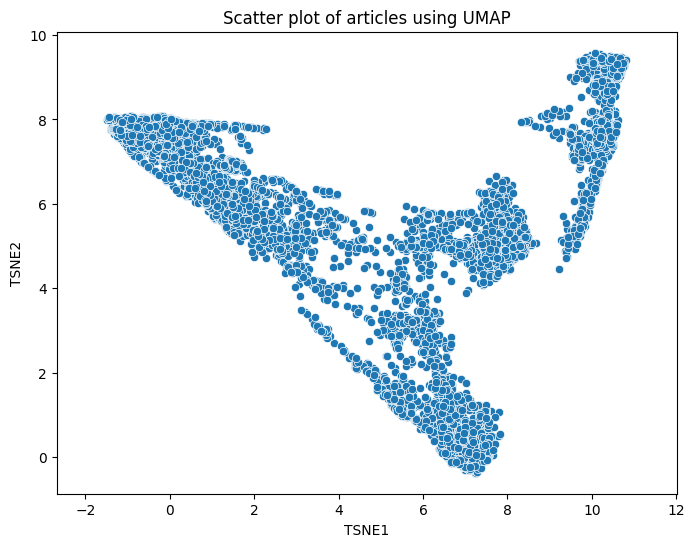

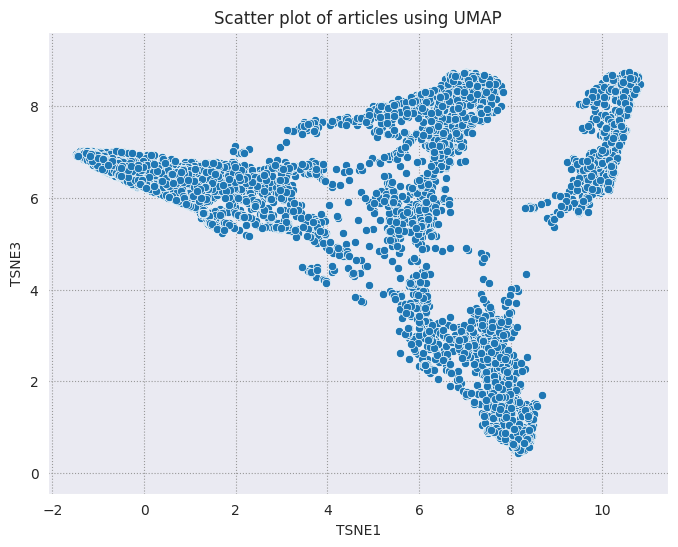

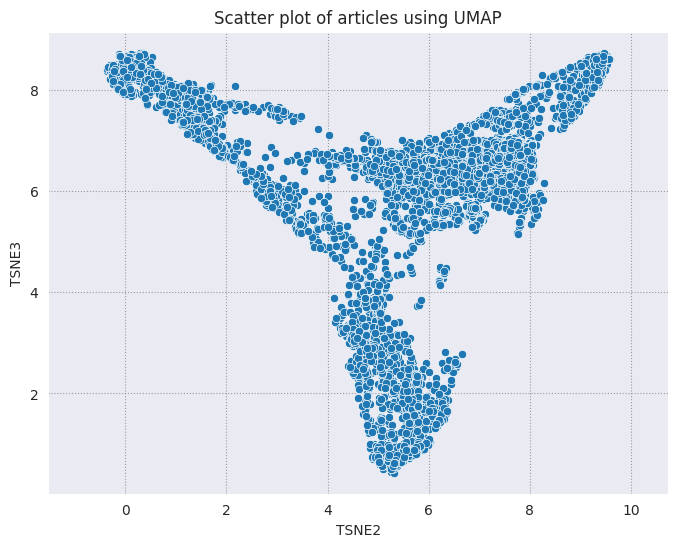

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='UMAP1', y='UMAP2')
plt.title('Scatter plot of articles using UMAP')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.axis('equal')

fig, ax = plt.subplots(figsize=(8,6))
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='UMAP1', y='UMAP3')
plt.title('Scatter plot of articles using UMAP')
plt.xlabel('TSNE1')
plt.ylabel('TSNE3')
plt.axis('equal')

fig, ax = plt.subplots(figsize=(8,6))
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='UMAP2', y='UMAP3')
plt.title('Scatter plot of articles using UMAP')
plt.xlabel('TSNE2')
plt.ylabel('TSNE3')
plt.axis('equal')

# **Clusterização (K-means)**

O K-means é um algoritmo de aprendizado não supervisionado amplamente utilizado para tarefas de agrupamento (clustering). Seu objetivo é particionar um conjunto de dados em k grupos (clusters), de modo que os pontos dentro de cada cluster sejam tão similares quanto possível, enquanto clusters distintos sejam dissimilares. O funcionamento do algoritmo baseia-se nos seguintes passos:

**Seleção de Centróides Iniciais**

1.   k pontos iniciais (centróides) são selecionados aleatoriamente ou por heurísticas.

2.   Atribuição de Pontos: Cada ponto do conjunto de dados é atribuído ao centróide mais próximo, com base em uma medida de distância (geralmente a Euclidiana).

3.   Atualização de Centróides: Os centróides são recalculados como a média dos pontos atribuídos a cada cluster.

4.   Iteração: Os passos 2 e 3 são repetidos até que a convergência seja atingida (i.e., os centróides não se alteram significativamente ou um número máximo de iterações é alcançado).

**Vantagens**

*   Simplicidade e eficiência computacional para conjuntos de dados de tamanho moderado.

*   Facilidade de interpretação dos resultados.

**Limitações**

*   Sensibilidade à inicialização dos centróides, podendo convergir para ótimos locais.

*   Necessidade de definir k previamente.

*   Dificuldade em lidar com clusters de formatos não esféricos ou de densidades variadas.






*   Análise de qualidade de clusters (silhouette score e regra do cotovelo)

*   Categorização automática por tópicos

*   Geração de word clouds por cluster

In [12]:
def kmeans(numero_de_clusters, generos):
  modelo = KMeans(n_clusters=numero_de_clusters, random_state=42, n_init=10)
  modelo.fit_predict(generos)
  silhouette_avg = silhouette_score(generos, modelo.labels_)
  return numero_de_clusters, modelo.inertia_,modelo,silhouette_avg

In [13]:
clusters = range(2, 41)
resultado_completo = [kmeans(numero_de_grupos, df_tsne[[f'UMAP{i+1}' for i in range(dimensoes)]]) for numero_de_grupos in clusters]

resultado = pd.DataFrame(resultado_completo,
            columns=['grupos', 'inertia', 'metodo','silhouette'])
resultado = resultado.drop(columns=["metodo"], axis=1)
resultado.head()

,grupos,inertia,silhouette
0,2,117916.546875,0.454639
1,3,80645.429688,0.481162
2,4,54746.628906,0.551908
3,5,40705.808594,0.472910
4,6,35135.636719,0.441154


# **Regra do Cotovelo (Elbow Method)**

A Regra do Cotovelo é uma técnica heurística utilizada para determinar o número ideal de clusters (k) em algoritmos de agrupamento como o K-means. O método consiste em calcular a soma dos quadrados intra-clusters (Within-Cluster Sum of Squares - WCSS) para diferentes valores de k e identificar o ponto em que o ganho de compactação diminui significativamente ("cotovelo").

WCSS: Mede a variabilidade total dentro dos clusters. Valores menores indicam clusters mais compactos.

**Procedimento**

*   Executar o K-means para uma variedade de valores de k (e.g.,k=1 a k=10).

*   Calcular o WCSS para cada k.

*   Plotar k versus WCSS e identificar o "cotovelo" no gráfico o ponto onde a curva deixa de decrescer abruptamente.

**Interpretação**

*   O k ideal é aquele no qual a adição de mais clusters não traz melhorias significativas na compactação.

**Limitações**

*   A identificação do "cotovelo" pode ser subjetiva em alguns casos, especialmente quando a curva é suave.

<Axes: >

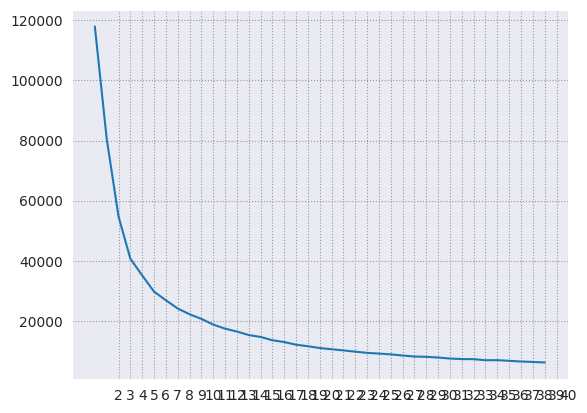

In [14]:
resultado.inertia.plot(xticks=resultado.grupos)

# **Silhouette Score**

O Silhouette Score é uma métrica de avaliação da qualidade de clusters, que combina medidas de coesão (distância intra-cluster) e separação (distância inter-clusters)

**Interpretação**

*   Valores próximos a +1 indicam clusters bem separados e coesos.

*   Valores próximos a 0 sugerem clusters sobrepostos.

*   Valores negativos indicam que pontos podem ter sido atribuídos a clusters incorretos.

**Vantagens**

*   Não depende do formato geométrico dos clusters.

*   Auxilia na seleção de k ao quantificar a qualidade do agrupamento.

**Aplicação**

*   Comparar diferentes valores de k, selecionando aquele com o maior Silhouette Score médio.

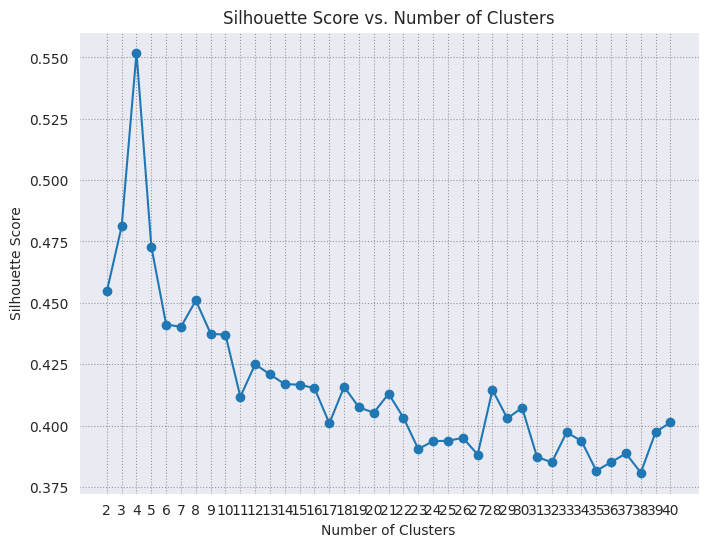

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(clusters, resultado['silhouette'], marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(clusters)
plt.grid(True)
plt.show()

# **Seleção do Número de Clusters**

Enquanto a Regra do Cotovelo oferece uma abordagem visual para estimar k, o Silhouette Score fornece uma avaliação quantitativa robusta. A combinação dessas técnicas é recomendada para validar a escolha do número de clusters e garantir a qualidade do agrupamento obtido pelo K-means.

In [16]:
numero_de_clusters,inertia,modelo,silhouette_avg = kmeans(4,df_tsne[['UMAP1', 'UMAP2', 'UMAP3']])
df_tsne['Cluster'] = modelo.labels_
print("Numero de clusters: " + str(numero_de_clusters) + " Inércia: %.2f" % inertia + f" Average silhouette_score is: {silhouette_avg}" )

Numero de clusters: 4 Inércia: 22237.36 Average silhouette_score is: 0.6971909999847412


# **Visualização 3D e Clouds dos Clusters**

A amostra reduzida foi submetida a algoritmos de clusterização não supervisionada para identificar grupos naturais de artigos. Posteriormente, um modelo de classificação supervisionada foi treinado utilizando os clusters identificados como rótulos, permitindo a categorização dos artigos restantes.

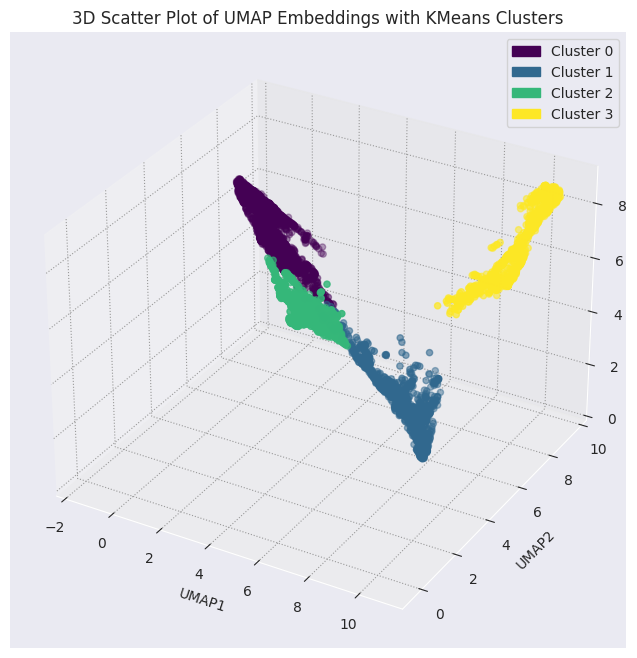

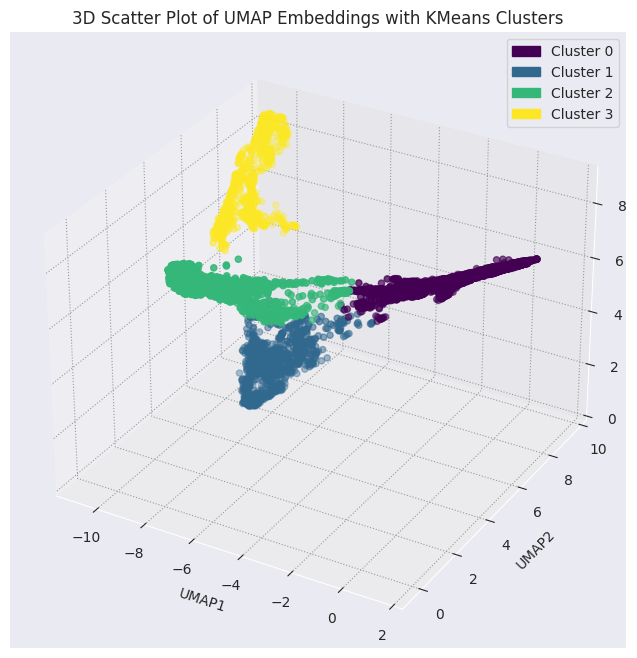

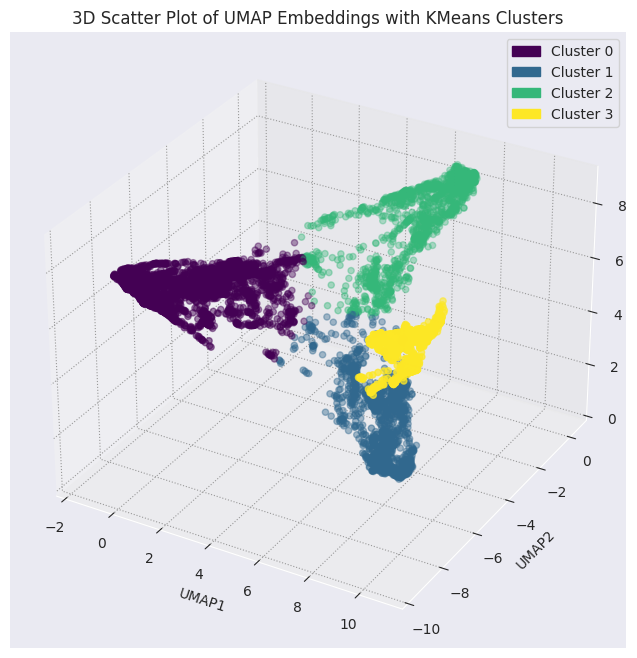

In [17]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

unique_clusters = sorted(df_tsne['Cluster'].unique())
cmap = plt.cm.get_cmap('viridis', len(unique_clusters))
colors = [cmap(i) for i in range(len(unique_clusters))]

legend_patches = []
for cluster, color in zip(unique_clusters, colors):
    patch = mpatches.Patch(color=color, label=f'Cluster {cluster}')
    legend_patches.append(patch)

scatter = ax.scatter(df_tsne['UMAP1'], df_tsne['UMAP2'], df_tsne['UMAP3'], c=df_tsne['Cluster'], cmap='viridis')

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
plt.title('3D Scatter Plot of UMAP Embeddings with KMeans Clusters')

ax.legend(handles=legend_patches)

plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

unique_clusters = sorted(df_tsne['Cluster'].unique())
cmap = plt.cm.get_cmap('viridis', len(unique_clusters))
colors = [cmap(i) for i in range(len(unique_clusters))]

legend_patches = []
for cluster, color in zip(unique_clusters, colors):
    patch = mpatches.Patch(color=color, label=f'Cluster {cluster}')
    legend_patches.append(patch)

scatter = ax.scatter(df_tsne['UMAP1']*(-1), df_tsne['UMAP2'], df_tsne['UMAP3'], c=df_tsne['Cluster'], cmap='viridis')

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
plt.title('3D Scatter Plot of UMAP Embeddings with KMeans Clusters')

ax.legend(handles=legend_patches)

plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

unique_clusters = sorted(df_tsne['Cluster'].unique())
cmap = plt.cm.get_cmap('viridis', len(unique_clusters))
colors = [cmap(i) for i in range(len(unique_clusters))]

legend_patches = []
for cluster, color in zip(unique_clusters, colors):
    patch = mpatches.Patch(color=color, label=f'Cluster {cluster}')
    legend_patches.append(patch)

scatter = ax.scatter(df_tsne['UMAP1'], df_tsne['UMAP2']*(-1), df_tsne['UMAP3'], c=df_tsne['Cluster'], cmap='viridis')

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
plt.title('3D Scatter Plot of UMAP Embeddings with KMeans Clusters')

ax.legend(handles=legend_patches)

plt.show()

In [18]:
def nuvem_palavras(textos):
    todas_palavras = ' '.join(textos)

    nuvem_de_palavras = WordCloud(width = 800, height = 500,max_font_size=110, collocations=False).generate(todas_palavras)
    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_de_palavras, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Generating word cloud for Cluster 0


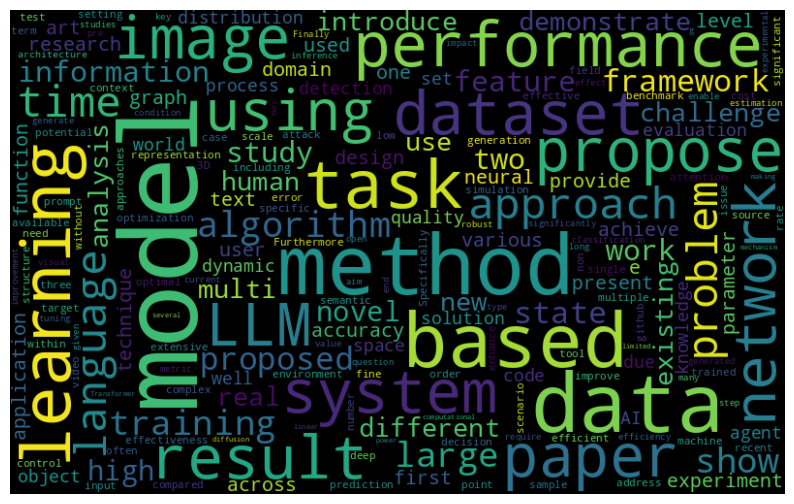

Generating word cloud for Cluster 1


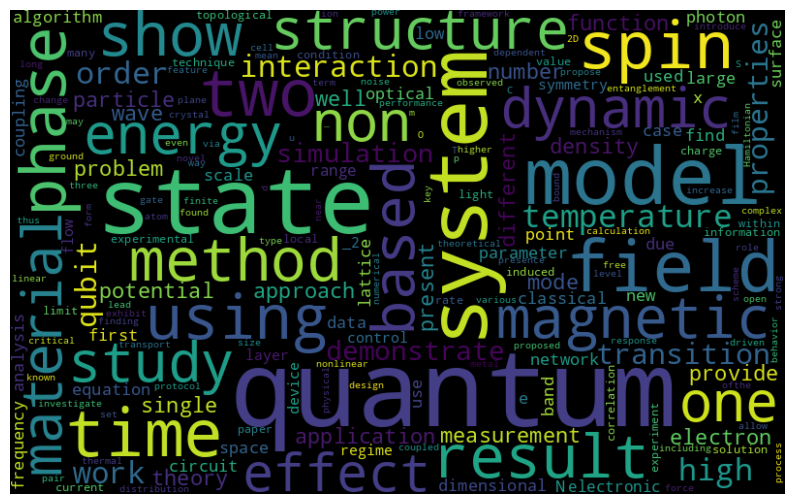

Generating word cloud for Cluster 2


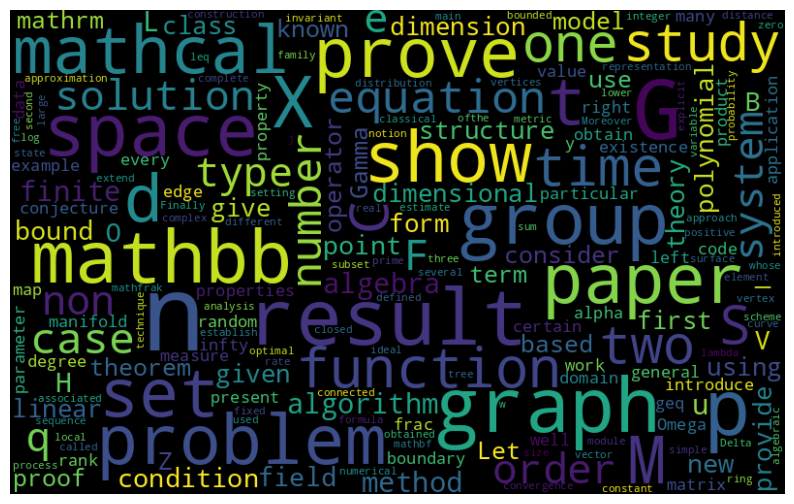

Generating word cloud for Cluster 3


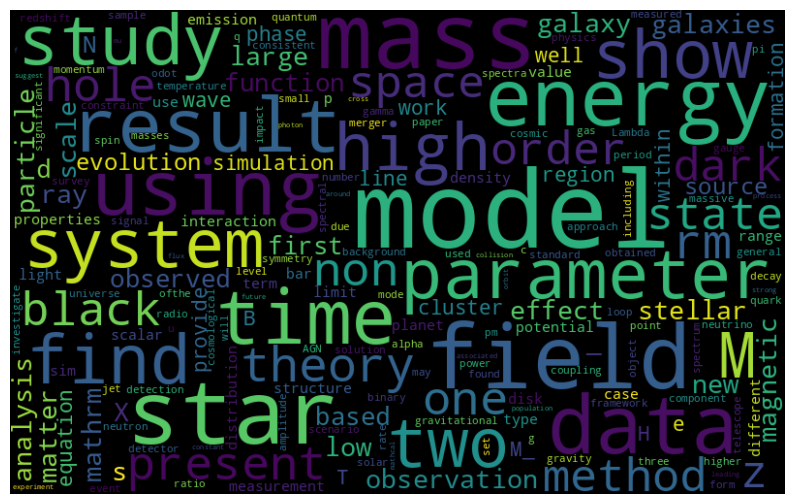

In [19]:
embeddings_sample_with_clusters = embeddings_sample.copy()
embeddings_sample_with_clusters['Cluster'] = df_tsne['Cluster'].values

for cluster_id in sorted(embeddings_sample_with_clusters['Cluster'].unique()):
    print(f"Generating word cloud for Cluster {cluster_id}")
    cluster_titles = embeddings_sample_with_clusters[embeddings_sample_with_clusters['Cluster'] == cluster_id]['content'].dropna()

    if len(cluster_titles) > 0:
        nuvem_palavras(cluster_titles)
    else:
        print(f"No titles found for Cluster {cluster_id}")

# **LDA (Latent Dirichlet Allocation)**

O algoritmo mais clássico para descobrir tópicos ocultos em uma coleção de textos. O resultado (os tópicos) pode ser visualizado de várias formas. A ferramenta mostra os tópicos em um espaço 2D, onde a distância entre eles representa a similaridade. Você pode ver as palavras mais relevantes para cada tópico. Gráficos de barras simples, mostrando as top-N palavras de cada tópico. Muito claro e direto.



In [20]:
def LDA_Textos(textos):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(textos)

    lda = LatentDirichletAllocation(n_components=4, random_state=42)
    lda.fit(dtm)

    pyLDAvis.enable_notebook()
    vis = pyLDAvis.lda_model.prepare(lda, dtm, vectorizer)
    display(vis)

In [21]:
for cluster_id in sorted(embeddings_sample_with_clusters['Cluster'].unique()):
    print(f"Generating LDA for Cluster {cluster_id}")
    cluster_titles = embeddings_sample[embeddings_sample_with_clusters['Cluster'] == cluster_id]['content'].dropna()

    if len(cluster_titles) > 0:
        LDA_Textos(cluster_titles)
    else:
        print(f"No titles found for Cluster {cluster_id}")

Generating LDA for Cluster 0


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.072023  0.114678       1        1  37.453445
2     -0.126544  0.018154       2        1  21.332918
3     -0.069162 -0.054276       3        1  21.094345
1      0.123683 -0.078556       4        1  20.119292, topic_info=              Term         Freq        Total Category  logprob  loglift
756             ai   599.000000   599.000000  Default  30.0000  30.0000
8286      language  1177.000000  1177.000000  Default  29.0000  29.0000
8574          llms  1056.000000  1056.000000  Default  28.0000  28.0000
7125         image   878.000000   878.000000  Default  27.0000  27.0000
12146     research   704.000000   704.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
16549         work   189.704766   810.108048   Topic4  -5.9929   0.1518
1552      approach   206.258071  1326.670061   Topic4  -5.9092  -0.2578
4487     different   179.470221   800.109073   Topic4  -6.0484   0.1088
10756  performance   190.499102  1595.514270   Topic4  -5.9887  -0.5218
12242      results   182.985970  1288.894347   Topic4  -6.0290  -0.3486

[380 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
152        1  0.843967        3d
152        3  0.154299        3d
347        3  0.038667  academic
347        4  0.947339  academic
495        1  0.130796   actions
...      ...       ...       ...
16549      4  0.234537      work
16574      1  0.447660     world
16574      2  0.036844     world
16574      3  0.344496     world
16574      4  0.171327     world

[755 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

Generating LDA for Cluster 1


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.118082  0.106883       1        1  27.970883
1     -0.087805  0.033439       2        1  27.360920
3      0.090027 -0.126307       3        1  24.007926
0     -0.120305 -0.014016       4        1  20.660271, topic_info=            Term         Freq        Total Category  logprob  loglift
5854     quantum  1443.000000  1443.000000  Default  30.0000  30.0000
6776        spin   487.000000   487.000000  Default  29.0000  29.0000
4334    magnetic   396.000000   396.000000  Default  28.0000  28.0000
156           _2   176.000000   176.000000  Default  27.0000  27.0000
5125     optical   219.000000   219.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
4871         non    78.144436   360.443350   Topic4  -5.7753   0.0482
6853       state    89.386094   564.421381   Topic4  -5.6408  -0.2659
5735  properties    68.065179   294.475339   Topic4  -5.9133   0.1122
6719       space    60.096736   202.185250   Topic4  -6.0379   0.3637
6961       study    63.009661   355.861481   Topic4  -5.9905  -0.1543

[332 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
46        1  0.979428    1t
80        1  0.727472    2d
80        2  0.028716    2d
80        3  0.239300    2d
80        4  0.009572    2d
...     ...       ...   ...
8346      1  0.201137  work
8346      2  0.350367  work
8346      3  0.207625  work
8346      4  0.243310  work
8393      2  0.926327  zeno

[650 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

Generating LDA for Cluster 2


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.034096  0.116940       1        1  28.394130
2     -0.089278 -0.107138       2        1  28.247704
3     -0.023107  0.024424       3        1  22.372208
1      0.146482 -0.034226       4        1  20.985958, topic_info=         Term        Freq       Total Category  logprob  loglift
2332    graph  276.000000  276.000000  Default  30.0000  30.0000
2338   graphs  269.000000  269.000000  Default  29.0000  29.0000
3157  mathcal  414.000000  414.000000  Default  28.0000  28.0000
2227    gamma  159.000000  159.000000  Default  27.0000  27.0000
1003    codes  117.000000  117.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
5476    using   54.591934  209.748025   Topic4  -5.7148   0.2153
4508     sets   44.801359  137.945226   Topic4  -5.9125   0.4367
4308  results   54.378784  325.364384   Topic4  -5.7187  -0.2277
4003    prove   57.424107  444.669731   Topic4  -5.6642  -0.4856
4822    study   51.282003  355.400129   Topic4  -5.7774  -0.3746

[320 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
30        1  0.965414    1d
96        3  0.971132    _i
99        1  0.037411    _n
99        2  0.860461    _n
99        3  0.093528    _n
...     ...       ...   ...
5586      3  0.037961  wave
5702      1  0.973384   x_0
5727      1  0.973368   z_2
5733      1  0.049694  zeta
5733      3  0.944188  zeta

[597 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

Generating LDA for Cluster 3


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.110862  0.111362       1        1  28.847415
1     -0.155457  0.049398       2        1  26.201315
2      0.083501 -0.089219       3        1  23.673349
0     -0.038906 -0.071541       4        1  21.277921, topic_info=        Term        Freq       Total Category  logprob  loglift
3783    mass  543.000000  543.000000  Default  30.0000  30.0000
4986     ray  184.000000  184.000000  Default  29.0000  29.0000
6168  theory  261.000000  261.000000  Default  28.0000  28.0000
821      bar  147.000000  147.000000  Default  27.0000  27.0000
4955   radio  125.000000  125.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
3954  models   55.561889  255.675455   Topic4  -5.8809   0.0211
6168  theory   52.972452  261.445143   Topic4  -5.9286  -0.0490
4147     non   51.760865  255.109534   Topic4  -5.9518  -0.0476
3714      m_   50.035107  173.732497   Topic4  -5.9857   0.3027
933    black   50.552398  244.052564   Topic4  -5.9754  -0.0269

[332 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
27        3  0.963153      07
37        1  0.241746      10
37        2  0.034535      10
37        3  0.477737      10
37        4  0.244624      10
...     ...       ...     ...
6835      1  0.259268    work
6835      2  0.388902    work
6835      3  0.209884    work
6835      4  0.141980    work
6871      4  0.966533  yukawa

[628 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

# **Preparação dos dados de treino e teste para o aprendizado de máquina não supervisionado.**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    np.stack(embeddings_sample['embedding']),
    df_tsne['Cluster'],
    test_size=0.2,
    random_state=42
)

In [23]:
def Avaliar(classifier, X_train, y_train, X_test, y_test):
    train_score = classifier.score(X_train, y_train)
    test_score = classifier.score(X_test, y_test)

    print(f"Acurácia Treino: {train_score:.3f}")
    print(f"Acurácia Teste: {test_score:.3f}")

    return classifier, clusters, (train_score, test_score)

# **Random Forest Classifier (Classificador de Floresta Aleatória)**

O Random Forest (Floresta Aleatória) é um algoritmo de aprendizado de máquina supervisionado que pertence à família de métodos ensemble. Especificamente, o **RandomForestClassifier** é utilizado para tarefas de classificação. Seu princípio fundamental é a construção de múltiplas árvores de decisão durante o treinamento e a combinação de suas previsões para obter um resultado mais preciso e robusto do que uma única árvore.

**Fundamentação Teórica e Funcionamento**

O funcionamento do Random Forest pode ser detalhado em três conceitos principais:

*   Bagging (Bootstrap Aggregating): O algoritmo cria múltiplas versões do conjunto de dados de treinamento através de amostragem com reposição (bootstrap). Isso significa que cada árvore da floresta é treinada em um subconjunto diferente e aleatório dos dados originais. Essa técnica introduz diversidade no ensemble, pois cada árvore "vê" uma porção ligeiramente diferente dos dados.

*   Aleatoriedade na Construção das Árvores: Durante a construção de cada árvore de decisão, não são consideradas todas as variáveis (features) disponíveis para encontrar a melhor divisão em cada nó. Em vez disso, em cada nó, um subconjunto aleatório de features é selecionado. Esta aleatoriedade força as árvores a serem diferentes umas das outras (reduzindo a correlação entre elas), fazendo com que cada uma se especialize em um aspecto diferente dos dados.

*   Votação Majoritária: Para classificar uma nova amostra, cada árvore na floresta emite seu "voto" (sua previsão individual). A previsão final do modelo é a classe que recebeu a maioria dos votos. Essa agregação suaviza o erro individual de cada árvore, levando a uma generalização superior.

**Vantagens do Random Forest Classifier**

*   Alta Precisão e Robustez: Geralmente oferece excelente desempenho em uma ampla variedade de problemas, competindo com algoritmos complexos como SVM e XGBoost.

*   Resistência ao Overfitting: Devido ao princípio de bagging e à média dos resultados, o modelo tende a não sobreajustar (overfit) aos dados de treinamento, mesmo que as árvores individuais sejam profundas.

*   Medição de Importância de Variáveis: O algoritmo fornece uma estimativa intrínseca da importância de cada variável preditora, baseada na diminuição média da impureza (Gini ou Entropia) que ela proporciona em todos os nós onde é utilizada.

*   Versatilidade: Pode lidar com dados numéricos e categóricos sem a necessidade de extensivo pré-processamento.

*   Não Paramétrico: Não faz suposições fortes sobre a distribuição dos dados subjacentes.

**Limitações e Considerações**

*   Interpretabilidade: Apesar de ser baseado em árvores de decisão (que são interpretáveis), uma floresta com centenas ou milhares de árvores funciona como uma "caixa preta", tornando difícil compreender a lógica exata por trás de uma previsão específica.

*   Consumo Computacional e Memória: O treinamento de um grande número de árvores pode ser computacionalmente intensivo e demandar mais memória, especialmente para conjuntos de dados muito grandes.

*   Tendência a "Ouvir" Demais os Dados: Em problemas com um número muito grande de features ruidosas, o modelo pode dar peso excessivo a correlações espúrias presentes nas amostras de bootstrap.

In [24]:
classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [25]:
Avaliar(classifier, X_train, y_train, X_test, y_test)

Acurácia Treino: 0.993
Acurácia Teste: 0.948


(RandomForestClassifier(class_weight='balanced', max_depth=20,
                        min_samples_leaf=10, min_samples_split=10,
                        n_estimators=200, n_jobs=-1, random_state=42),
 range(2, 41),
 (0.99265625, 0.948125))

# **XGBoost Classifier (eXtreme Gradient Boosting)**

O XGBoost (eXtreme Gradient Boosting) é um algoritmo de aprendizado de máquina supervisionado que pertence à família dos métodos de Gradient Boosting. O XGBClassifier é sua implementação para problemas de classificação. Desenvolvido para ser altamente eficiente, flexível e portável, tornou-se uma ferramenta extremamente popular e frequentemente dominante em competições de ciência de dados e aplicações do mundo real.

**Fundamentação Teórica e Funcionamento**

O XGBoost é uma evolução sofisticada do algoritmo de Gradient Boosting, baseando-se nos seguintes princípios fundamentais:

*   Gradient Boosting Framework: O método constrói um modelo preditivo forte de forma sequencial e aditiva, combinando múltiplos modelos fracos (geralmente árvores de decisão rasas). Cada nova árvore é treinada para corrigir os resíduos (erros) das árvores anteriores. Especificamente, ela é ajustada ao gradiente negativo da função de perda em relação às previsões atuais.

*   Função Objetivo Otimizada: A inovação central do XGBoost está em sua função objetivo, que combina uma função de perda (ex.: log loss para classificação) com um termo de regularização que penaliza a complexidade do modelo.

*   Aproximação de Segunda Ordem: Enquanto o Gradient Boosting tradicional usa apenas o gradiente (primeira derivada) da função de perda, o XGBoost utiliza também a Hessiana (segunda derivada). Isso fornece mais informação sobre a direção e a curvatura da função de perda, resultando em uma convergência mais rápida e precisa.

*   Algoritmo Eficiente para Busca de Divisões: O XGBoost emprega um algoritmo histogram-based para encontrar a melhor divisão em um nó de árvore, que é significativamente mais rápido do que métodos exatos. Ele também lida com valores faltantes automaticamente, aprendendo a direção padrão (esquerda ou direita) para enviar exemplos com dados missing.

*   Paralelização e Otimizações Computacionais: Ao contrário da crença popular, o boosting é inerentemente sequencial. No entanto, o XGBoost paraleliza o processo de construção das árvores internamente, otimizando o cálculo dos ganhos para todas as divisões candidatas. Isso o torna excepcionalmente rápido.

**Vantagens do XGBClassifier**

*   Alta Performance e Precisão: Consistentemente produz resultados de alto nível, superando a maioria dos outros algoritmos em uma ampla gama de datasets.

*   Regularização Incorporada: A inclusão nativa de termos de regularização (L1 e L2) o torna muito resistente ao overfitting.

*   Extrema Velocidade e Escalabilidade: Projetado para ser computacionalmente eficiente, podendo lidar com grandes volumes de dados.

*   Versatilidade: Suporta vários tipos de problemas (classificação, regressão, ranking), funções de perda personalizadas e diferentes estruturas de dados.

*   Tratamento Automático de Dados Faltantes: O algoritmo decide automaticamente a melhor maneira de lidar com valores missing durante o treinamento.

*   Importância de Variáveis: Fornece uma estimativa robusta da importância das features, baseada no ganho médio que cada uma proporciona quando usada nas divisões das árvores.

**Limitações e Considerações**

*   Complexidade de Ajuste (Hiperparâmetros): Possui um número considerável de hiperparâmetros que podem ser ajustados. Encontrar a configuração ótima pode ser um processo demorado e que requer conhecimento.

*   Risco de Overfitting em Datasets Pequenos: Apesar da regularização, se não for devidamente ajustado, pode ainda sofrer de overfitting em conjuntos de dados muito pequenos ou ruidosos.

*   Interpretabilidade: Assim como o Random Forest, é um modelo de ensemble complexo, tornando-o menos interpretável do que uma árvore de decisão única. Técnicas como SHAP são frequentemente usadas para explicar suas previsões.

In [26]:
classifier = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

In [27]:
Avaliar(classifier, X_train, y_train, X_test, y_test)

Acurácia Treino: 1.000
Acurácia Teste: 0.956


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=100,
               n_jobs=-1, num_parallel_tree=None, ...),
 range(2, 41),
 (1.0, 0.955625))

# **SVC (Support Vector Classification)**

O SVC ou Support Vector Classification é um algoritmo de aprendizado de máquina supervisionado baseado na teoria das Support Vector Machines (SVMs). Ele é utilizado para problemas de classificação e se destaca por sua fundamentação teórica sólida na teoria estatística de aprendizado e por sua capacidade de criar fronteiras de decisão complexas e robustas.

**Fundamentação Teórica e Funcionamento**

O princípio fundamental do SVC é encontrar o hiperplano ótimo que maximize a margem de separação entre classes diferentes. Sua operação pode ser compreendida através dos seguintes conceitos:

*   Hiperplano e Margem Máxima: Em um espaço dimensional, um hiperplano é uma superfície plana que divide o espaço em dois semi-espaços. Para classificação binária, o SVC busca o hiperplano que não apenas separa as classes, mas que maximize a distância (margem) entre os pontos mais próximos de cada classe. A margem é definida pela distância entre o hiperplano e os vetores de suporte - que são os pontos de dados mais difíceis de classificar, localizados exatamente na borda da margem.

*   Classificação com Margem Suave (Soft Margin): Para dados que não são linearmente separáveis, o SVC introduz o conceito de margem suave, que permite que alguns pontos violarem a margem. Isso é controlado pelo parâmetro de regularização C.

*   O parâmetro C estabelece um trade-off: valores altos de C penalizam fortemente os erros de classificação (margem estreita, possivelmente overfitting), enquanto valores baixos permitem mais violações (margem mais ampla, modelo mais generalizável).

*   Kernel Trick (Truque do Kernel): Para problemas onde os dados não são linearmente separáveis no espaço original, o SVC utiliza funções kernel para mapear os dados para um espace de características de dimensão superior, onde se torna possível a separação linear.

O "truque" do kernel é que este mapeamento é feito implicitamente, sem a necessidade de calcular explicitamente as coordenadas no espaço de alta dimensão, o que seria computacionalmente inviável.

Processo de Classificação

*   Treinamento: O algoritmo resolve um problema de otimização quadrática para encontrar os vetores de suporte e determinar os parâmetros do hiperplano ótimo.

*   Predição: Para uma nova amostra, a decisão de classificação é tomada com base em qual lado do hiperplano a amostra se encontra.

**Vantagens do SVC**

*   Eficácia em Espaços de Alta Dimensionalidade: Funciona bem mesmo quando o número de features é maior que o número de amostras.

*   Versatilidade através de Kernels: A capacidade de usar diferentes funções kernel permite modelar relações complexas e não-lineares nos dados.

*   Robustez e Generalização: O foco na maximização da margem tende a levar a modelos com boa capacidade de generalização, resistentes ao overfitting, especialmente com parâmetros adequados.

*   Eficiência de Memória: Utiliza apenas os vetores de suporte para fazer predições, não necessitando armazenar todo o conjunto de dados de treinamento.

*   Fundamentação Teórica Sólida: Baseado na Teoria de Aprendizado Estatístico de Vapnik-Chervonenkis (VC theory), que fornece garantias teóricas sobre o desempenho.

**Limitações e Considerações**

*   Escalabilidade Computacional: O tempo de treinamento pode ser proibitivo para conjuntos de dados muito grandes (com milhões de amostras), pois a complexidade geralmente é O(n²) a O(n³).

*   Sensibilidade a Hiperparâmetros: O desempenho é altamente dependente da escolha adequada do kernel e dos parâmetros C e gamma (para kernels RBF).

*   Interpretabilidade Limitada: Modelos SVC com kernels não-lineares funcionam como "caixas pretas", tornando difícil entender a relação exata entre as features e a predição.

*   Desempenho em Datasets Muito Grandes: Algoritmos baseados em árvores (como XGBoost) podem ser mais eficientes e performáticos em certos cenários com big data.

*   Requer Pré-processamento: É crucial escalonar as features (ex.: StandardScaler) antes de aplicar o SVC, pois o algoritmo é sensível à escala dos dados.

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifier = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True
)

classifier.fit(X_train_scaled, y_train)

SVC(probability=True)

In [29]:
Avaliar(classifier, X_train_scaled, y_train, X_test_scaled, y_test)

Acurácia Treino: 0.998
Acurácia Teste: 0.971


(SVC(probability=True), range(2, 41), (0.9978125, 0.97125))

# **TensorFlow Keras Sequential**

O TensorFlow Keras Sequential representa uma interface de programação de alto nível para a construção de modelos de redes neurais profundas seguindo uma arquitetura sequencial linear. Esta abordagem simplifica significativamente o processo de desenvolvimento de modelos de aprendizado profundo, organizando as camadas da rede neural em uma estrutura de pilha onde o fluxo de informação ocorre de maneira unidirecional, da entrada para a saída, sem retroalimentações ou ramificações complexas.

**Fundamentação Conceitual e Arquitetural**

A essência do modelo Sequential reside em sua organização linear de camadas, formando um grafo computacional acíclico direcionado. Cada camada processa os dados recebidos da camada anterior e transmite sua saída para a camada subsequente, criando uma cadeia de transformações progressivas dos dados de entrada. Esta arquitetura é particularmente adequada para redes neurais feedforward convencionais, onde a informação flui exclusivamente em direção à saída, sem ciclos ou conexões paralelas complexas.

**Características Estruturais Principais**

O Sequential caracteriza-se por sua natureza modular, onde diversas tipologias de camadas podem ser integradas de forma coesa. Entre as camadas mais comumente utilizadas destacam-se as camadas densamente conectadas, apropriadas para processamento de características em rede neural artificial tradicional; camadas convolucionais, especializadas no processamento de dados com estrutura espacial como imagens; camadas recorrentes, desenhadas para sequências temporais; além de camadas auxiliares como mecanismos de regularização por dropout, operações de pooling e normalização.

**Fluxo de Desenvolvimento Característico**

O processo de construção e utilização de um modelo Sequential desdobra-se em quatro estágios fundamentais. Inicialmente, ocorre a definição arquitetural, onde as camadas são organizadas sequencialmente, sendo imperativo que a camada inicial especifique a dimensionalidade dos dados de entrada. Subsequentemente, o modelo é compilado, etapa que envolve a seleção do algoritmo de otimização, definição da função de custo e estabelecimento das métricas de avaliação de desempenho.

A terceira fase consiste no treinamento propriamente dito, onde o modelo ajusta seus parâmetros através de exposição iterativa aos dados de treinamento, com monitoramento simultâneo do desempenho em conjunto de validação. Por fim, o modelo é submetido à fase de avaliação e predição, onde sua capacidade de generalização é mensurada em dados não vistos durante o treinamento e utilizado para inferências sobre novas observações.

**Vantagens Inerentes ao Paradigma Sequential**

Dentre as principais vantagens desta abordagem, ressalta-se sua simplicidade conceitual e operacional, que permite a prototipagem acelerada de modelos complexos com esforço de codificação significativamente reduzido. A natureza linear da arquitetura facilita substancialmente processos de depuração e interpretação do fluxo de dados. Adicionalmente, o modelo beneficia-se da integração nativa com o ecossistema TensorFlow e da extensa documentação e suporte comunitário disponível.

**Limitações e Considerações Aplicativas**

Apesar de sua versatilidade, o modelo Sequential apresenta restrições importantes em cenários que demandam arquiteturas não sequenciais. Sua estrutura linear não suporta nativamente a implementação de modelos com múltiplas entradas ou saídas, conexões residuais, compartilhamento de camadas ou topologias com ramificações paralelas. Para tais casos, a Functional do Keras oferece maior flexibilidade arquitetural. Outra consideração relevante refere-se ao limitado controle de fluxo para implementação de mecanismos complexos como atenção adaptativa ou memória seletiva.

In [30]:
model = Sequential([
    Dense(1024, activation='relu', input_shape=(3072,)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(numero_de_clusters, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,811,076 (14.54 MB)

 Trainable params: 3,807,492 (14.52 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [31]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=0.0001
)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.7938 - loss: 0.6215 - val_accuracy: 0.9180 - val_loss: 0.3840 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.9688 - loss: 0.0877 - val_accuracy: 0.9438 - val_loss: 0.2488 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9870 - loss: 0.0405 - val_accuracy: 0.9531 - val_loss: 0.1751 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9904 - loss: 0.0299 - val_accuracy: 0.9578 - val_loss: 0.1594 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.9919 - loss: 0.0241 - val_accuracy: 0.9641 - val_loss: 0.1392 - learning_rate: 0.0010
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9950 - loss: 0.0208 - val_accuracy: 0.9688 - val_loss: 0.1410 - learning_rate: 0.0010
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9951 - loss: 0.012

In [32]:
model.evaluate(x=X_test_scaled, y=y_test, return_dict=True)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9703 - loss: 0.1083


{'accuracy': 0.9681249856948853, 'loss': 0.12122560292482376}

# **Desempenho do Modelo de Classificação**

O modelo de classificação desenvolvido para categorizar os artigos científicos nos clusters identificados alcançou uma acurácia notável de 97,1%. Este resultado excepcional demonstra a eficácia da abordagem proposta e a qualidade dos embeddings e clusters gerados na fase anterior do projeto.

**Análise do Resultado**

A alta acurácia de 97,1% indica que:

*   Qualidade dos Embeddings: Os embeddings gerados pelo modelo text-embedding-3-large capturam efetivamente as características semânticas e temáticas dos artigos, permitindo uma distinção clara entre diferentes domínios científicos.

*   Eficácia da Clusterização Inicial: A estratégia de clusterização na amostra de 8.000 artigos produziu grupos coerentes e bem delimitados, proporcionando rótulos de alta qualidade para o treinamento supervisionado.

*   Representatividade da Amostra: A amostra de 3,6% do total mostrou-se estatisticamente representativa, contendo padrões suficientes para generalizar para os 222.259 artigos.

*   Adequação do Pipeline UMAP + Classificação: A redução dimensional com UMAP preservou informações relevantes para a distinção entre categorias, facilitando o trabalho do classificador.

**Implicações Práticas**

Esta alta taxa de acurácia tem implicações significativas para o sistema proposto:

*   Confiabilidade na Organização Automática: Com 97,1% de precisão, os usuários podem confiar que os artigos estão sendo direcionados para as bibliotecas especializadas corretas.

*   Redução de Erros de Categorização: Apenas 2,9% dos artigos podem necessitar de revisão ou reclassificação, representando um custo computacional mínimo para correções manuais.

*   Escalabilidade Comprovada: O sucesso na classificação do restante dos artigos valida a estratégia de usar uma amostra reduzida para treinamento.

# **Conclusão**

A abordagem proposta demonstra a viabilidade de organizar grandes coleções científicas através de técnicas modernas de PLN e aprendizado de máquina. A estratégia de amostragem seguida de classificação em escala mostrou-se eficiente tanto computacionalmente quanto em termos de qualidade na categorização, oferecendo uma solução escalável para o desafio da gestão de grandes volumes de informação científica.